In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
import kaggle
from sklearn.metrics import make_scorer 

# # ignore Warning
# import warnings
# warnings.filterwarnings("ignore") 

In [2]:
train = pd.read_csv('files_csv/train.csv')
test = pd.read_csv('files_csv/test.csv')

print(train.shape)
print(test.shape)

train.columns.values

(1460, 81)
(1459, 80)


array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

In [3]:
train_ID = train['Id']
test_ID = test['Id']
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

## Analyse SalePrice

In [4]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


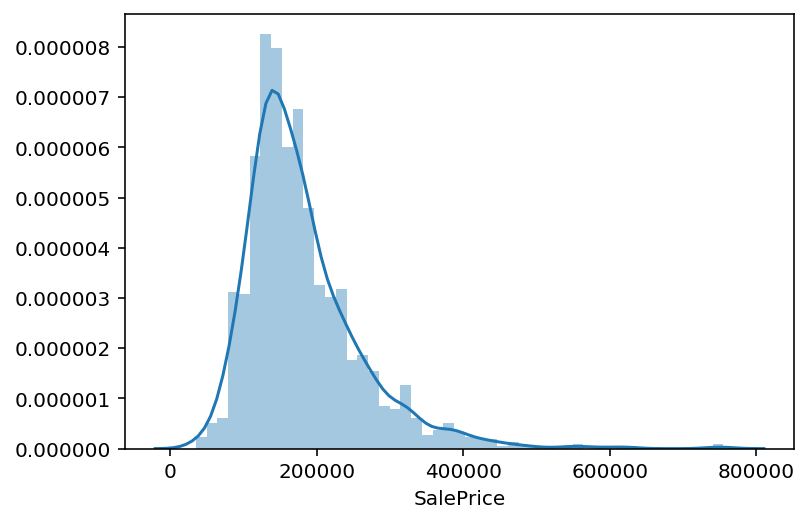

In [5]:
sns.distplot(train['SalePrice'])

log(SalePrice) pour une distribution "normale"

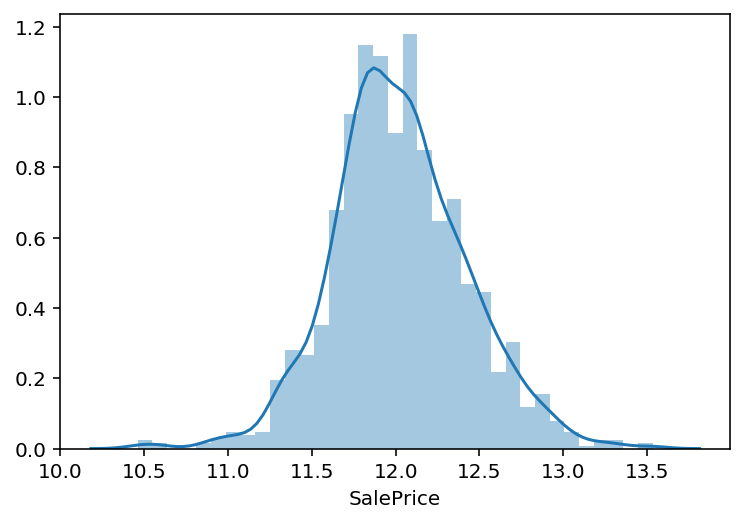

In [6]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'])

## Division des datas en valeurs numériques ( quantitative ) et catégorielles ( qualititative ) 

In [7]:
train.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 80, dtype: object

In [8]:
# quali
qual = train.select_dtypes(include=['object']).columns
print(qual)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [9]:
#quanti
quan = train.select_dtypes(include=['int64','float64']).columns
quan = quan.drop(pd.Index(['SalePrice']))
print(quan)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [10]:
num_quan = len(train.select_dtypes(include=['int64','float64']).columns)
num_qual = len(train.select_dtypes(include=['object']).columns)

print(f"{num_quan} features numériques & {num_qual} features catégorielles")

37 features numériques & 43 features catégorielles


In [11]:
corrmat = train.corr()

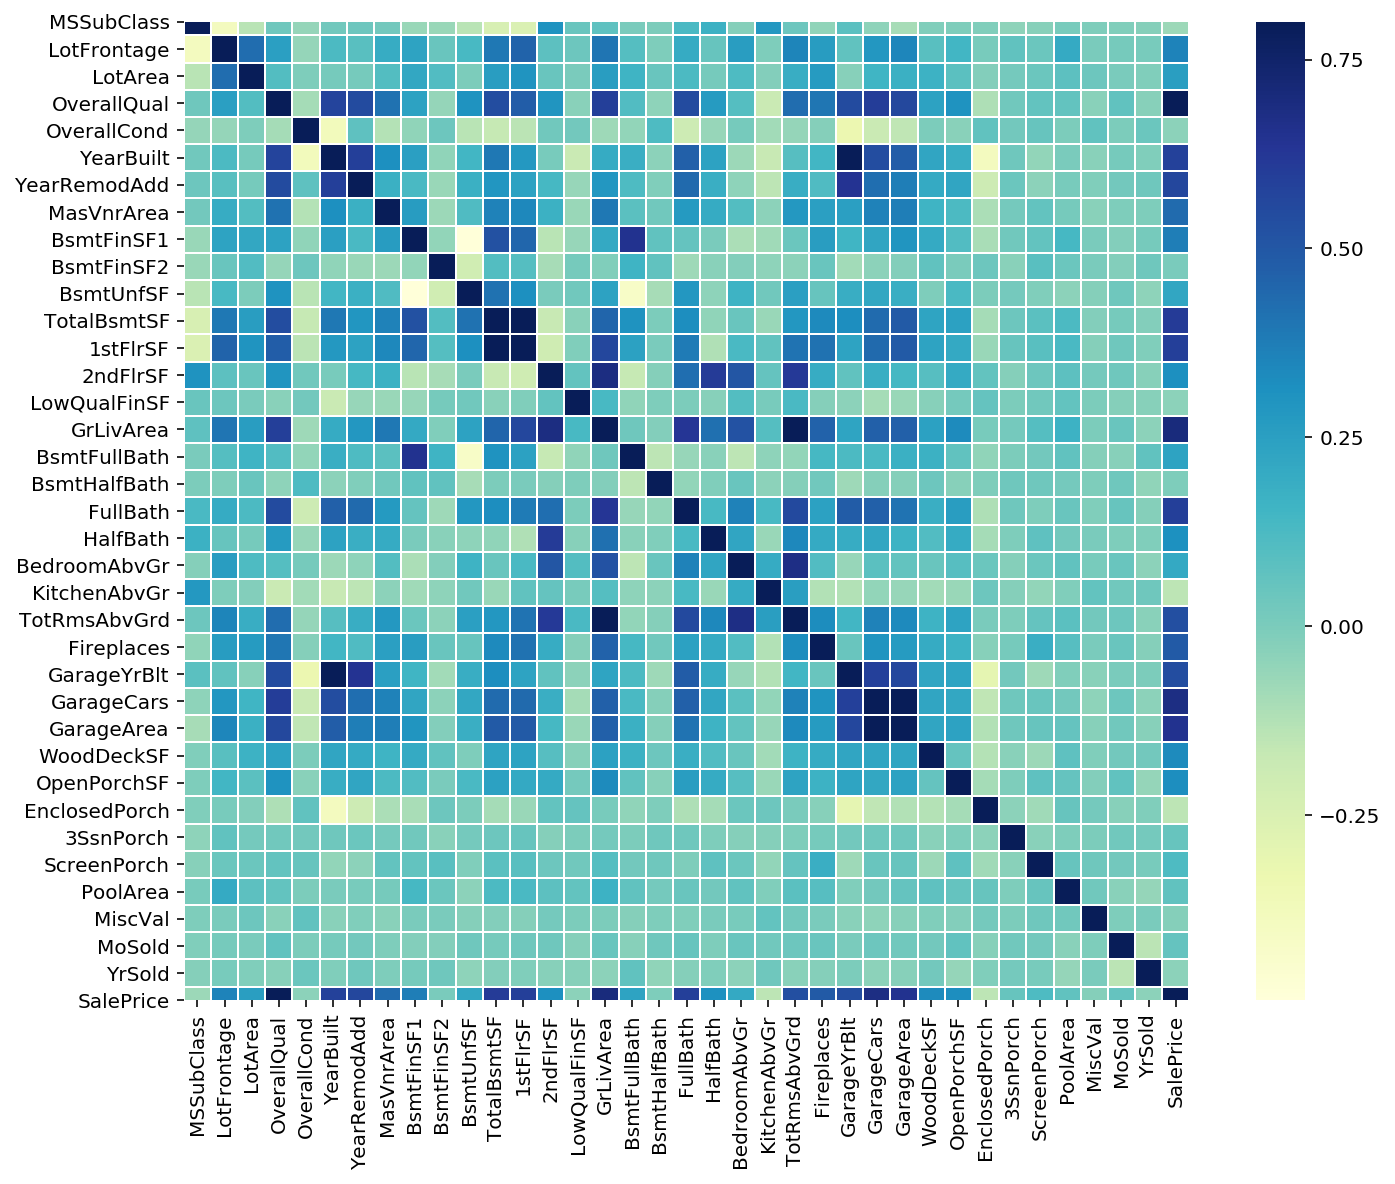

In [12]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, linewidths=.5, cmap="YlGnBu");

## 10 Features + corrélées avec l'output

In [13]:
train[quan]
corr_output = dict()

for x in train[quan]:
    corr_output[x] = round(train[x].corr(train['SalePrice']),2)
    
for key in sorted(corr_output,key =corr_output.get, reverse=True):
    if corr_output[key] >= 0.5:
            print(key, corr_output[key])  
            

# corr_mat de ces 10 features

k = 11
cols = corrmat.nlargest(k,'SalePrice').index
cols 

corr_mat_10 = train[cols].corr()
corr_mat_10

OverallQual 0.82
GrLivArea 0.7
GarageCars 0.68
GarageArea 0.65
TotalBsmtSF 0.61
1stFlrSF 0.6
YearBuilt 0.59
FullBath 0.59
YearRemodAdd 0.57
GarageYrBlt 0.54
TotRmsAbvGrd 0.53


,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,YearBuilt,YearRemodAdd,GarageYrBlt
SalePrice,1.000000,0.817185,0.700927,0.680625,0.650888,0.612134,0.596981,0.594771,0.586570,0.565608,0.541073
OverallQual,0.817185,1.000000,0.593007,0.600671,0.562022,0.537808,0.476224,0.550600,0.572323,0.550684,0.547766
GrLivArea,0.700927,0.593007,1.000000,0.467247,0.468997,0.454868,0.566024,0.630012,0.199010,0.287389,0.231197
GarageCars,0.680625,0.600671,0.467247,1.000000,0.882475,0.434585,0.439317,0.469672,0.537850,0.420622,0.588920
GarageArea,0.650888,0.562022,0.468997,0.882475,1.000000,0.486665,0.489782,0.405656,0.478954,0.371600,0.564567
TotalBsmtSF,0.612134,0.537808,0.454868,0.434585,0.486665,1.000000,0.819530,0.323722,0.391452,0.291066,0.322445
1stFlrSF,0.596981,0.476224,0.566024,0.439317,0.489782,0.819530,1.000000,0.380637,0.281986,0.240379,0.233449
FullBath,0.594771,0.550600,0.630012,0.469672,0.405656,0.323722,0.380637,1.000000,0.468271,0.439046,0.484557
YearBuilt,0.586570,0.572323,0.199010,0.537850,0.478954,0.391452,0.281986,0.468271,1.000000,0.592855,0.825667
YearRemodAdd,0.565608,0.550684,0.287389,0.420622,0.371600,0.291066,0.240379,0.439046,0.592855,1.000000,0.642277


- OverallQual : Evalue les matériaux et la finition de la maison
- GrLivArea : Surface habitable ( pieds carrés ) 
- GarageCars : Capacité du garage en nombres de voitures
- GarageArea : Taille du garage en pieds carrés
- TotalBsmSF : Superficie du sous sol ( pieds carrés ) 
- 1stFrlSF : Superficie du premier étage ( pieds carrés ) 
- FullBath : Salles de bains ( qui ne sont pas au sous sol ) 
- TotalRmsAbvGrd : Total de pieces au niveau du sol ( ne comprend pas les salles de bains ) 
- YearBuild : Année de construction
- YearRemodAdd : Date " remodelage " ( ? ) ( identique à la date de constructions si aucun ajout ) 

## Analyse features numériques

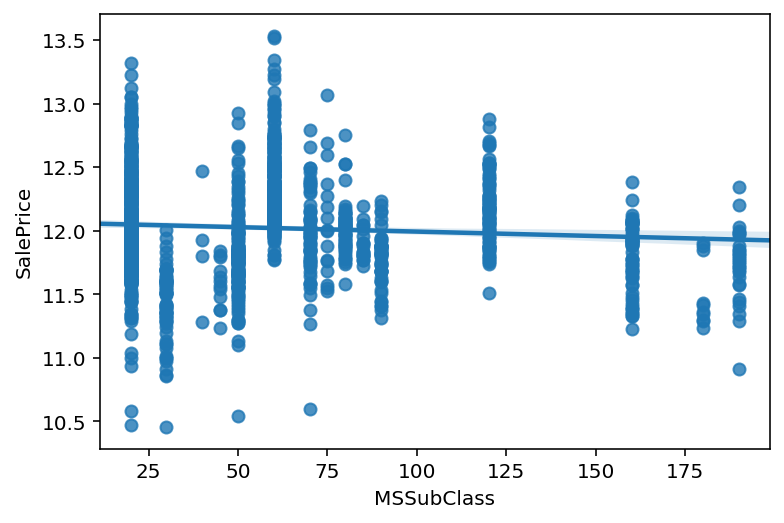

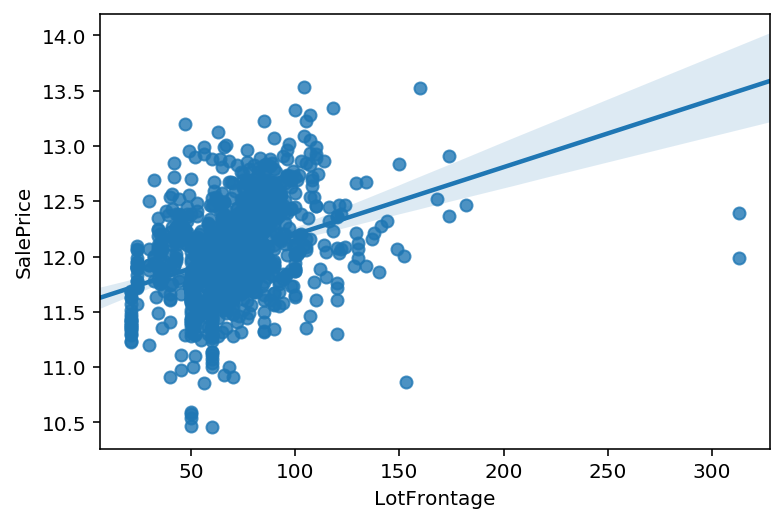

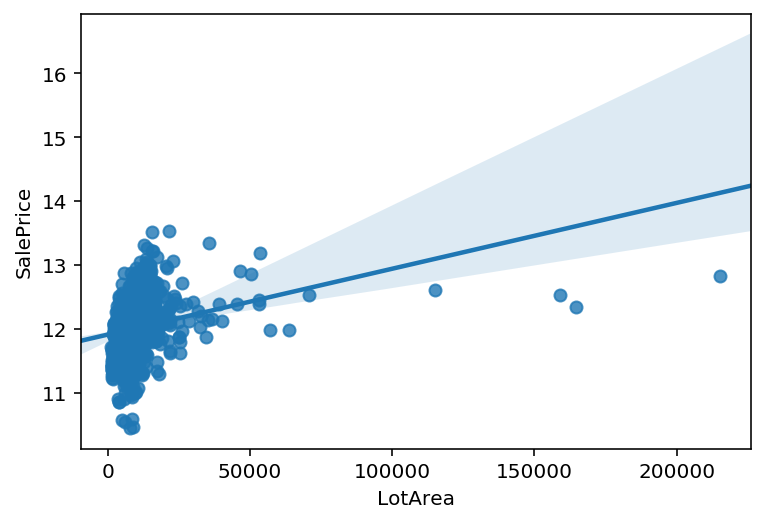

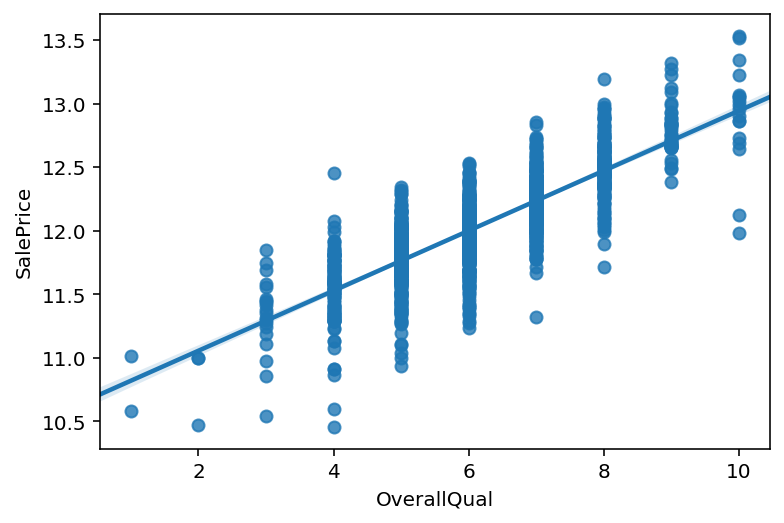

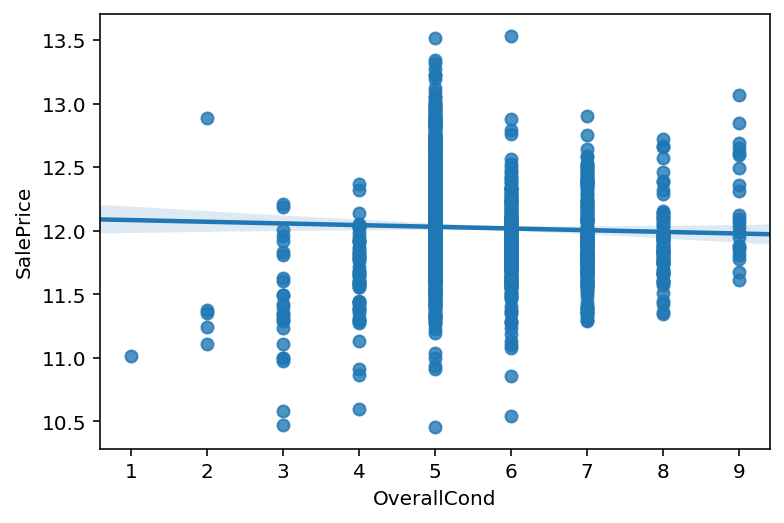

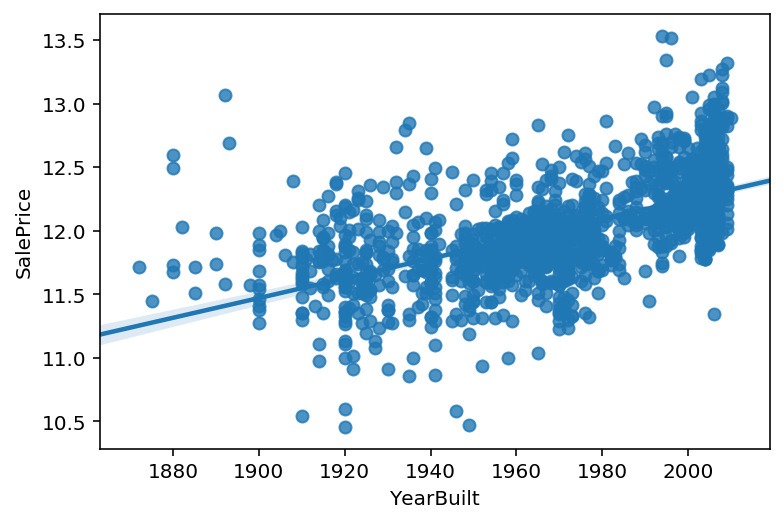

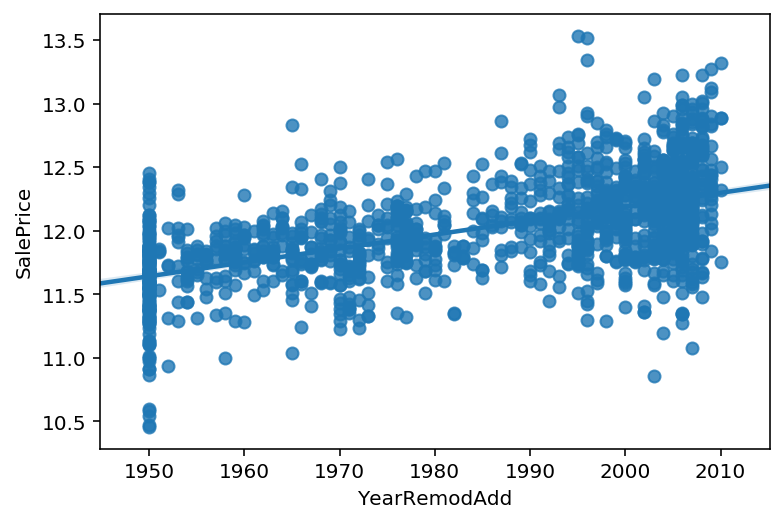

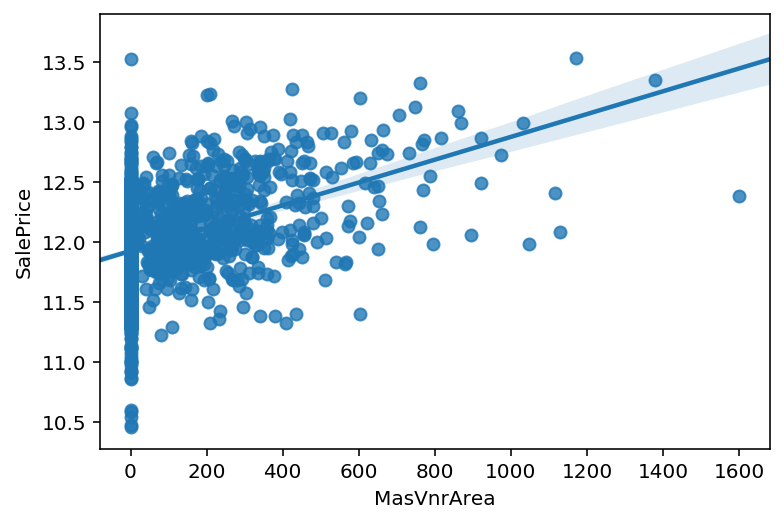

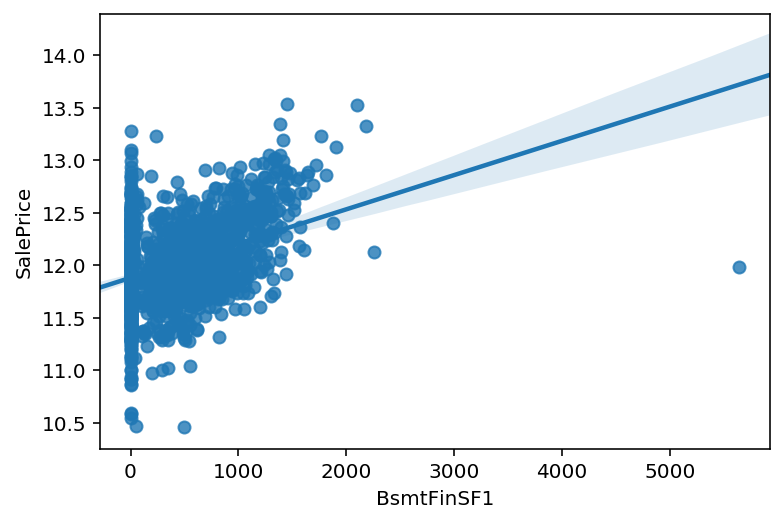

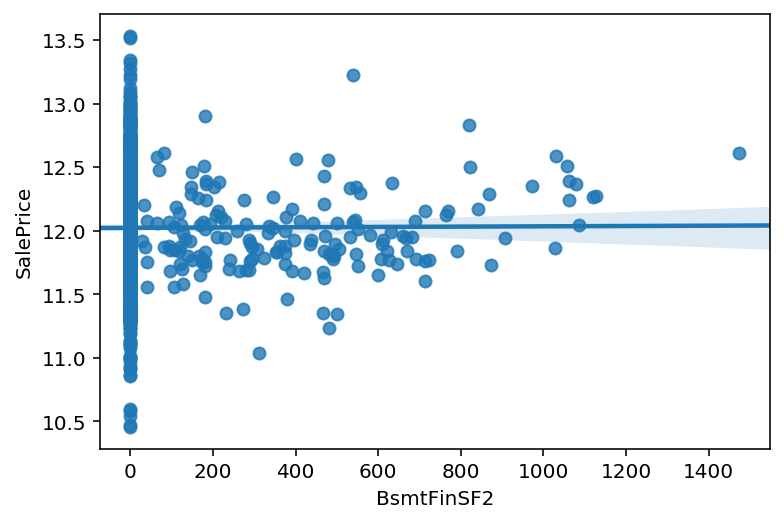

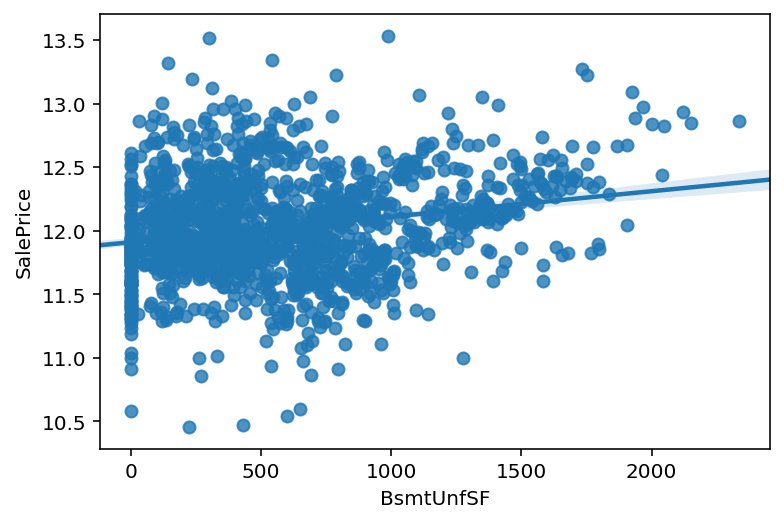

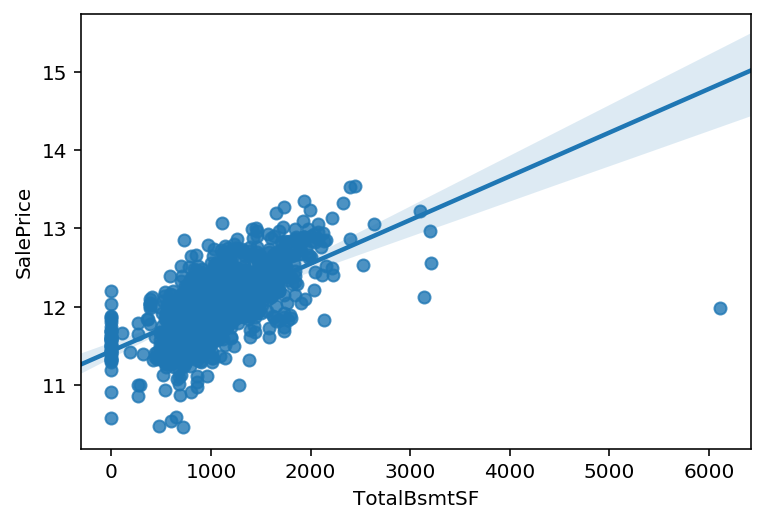

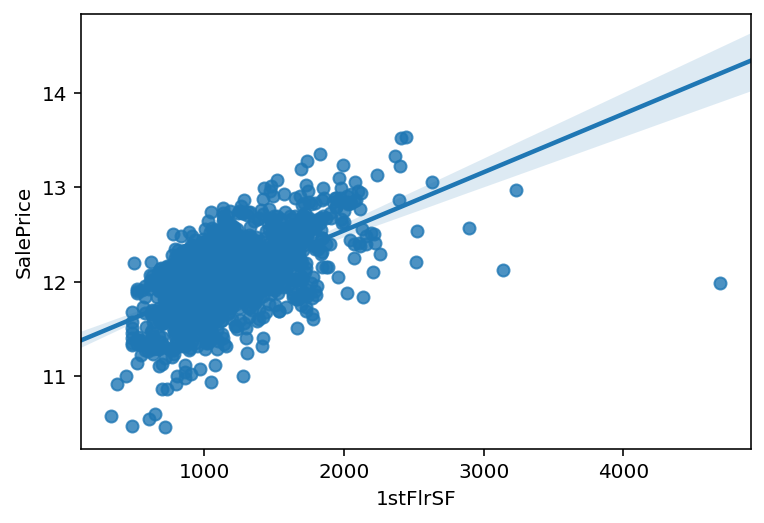

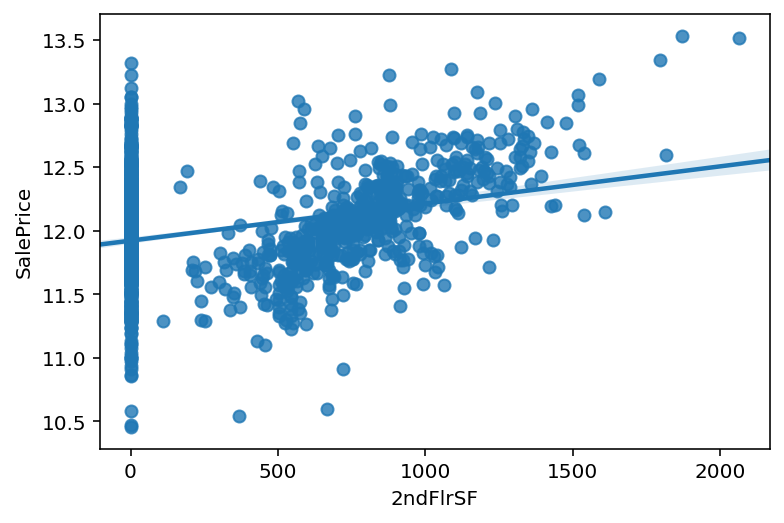

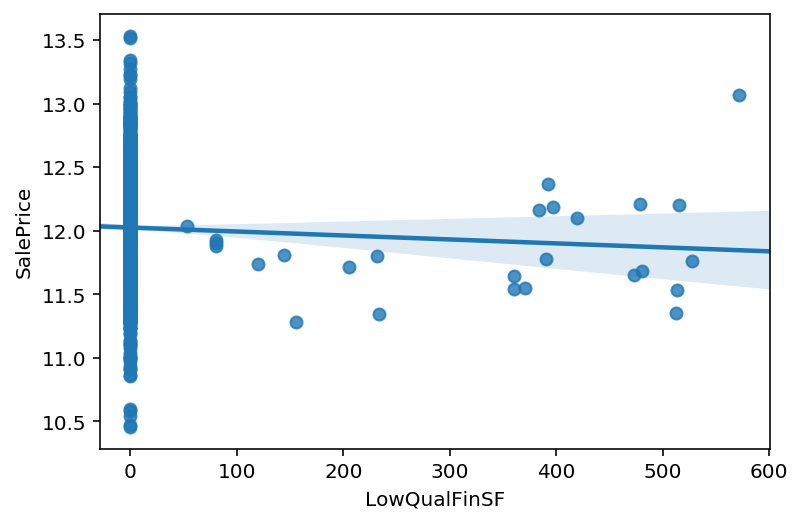

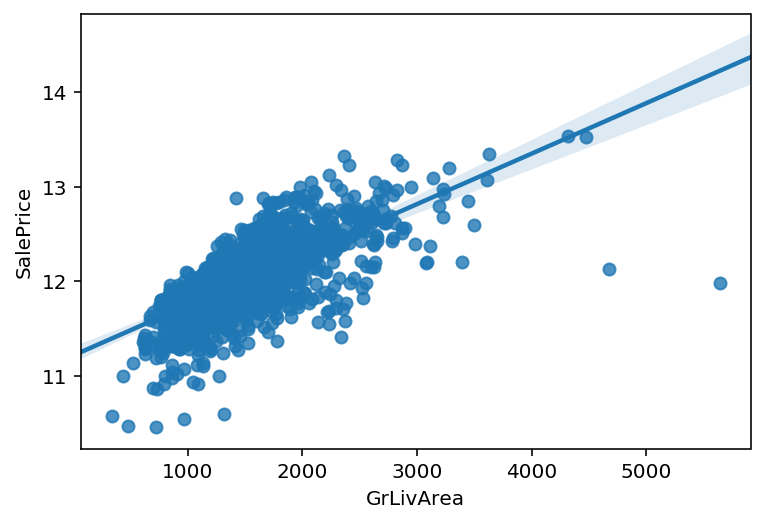

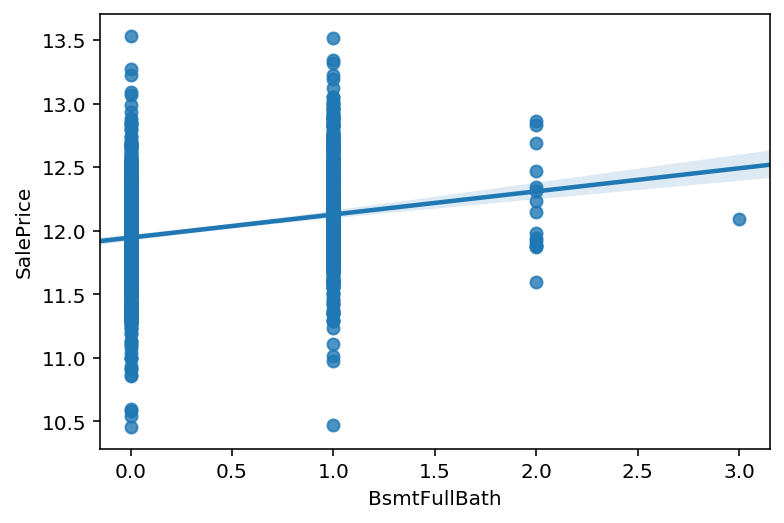

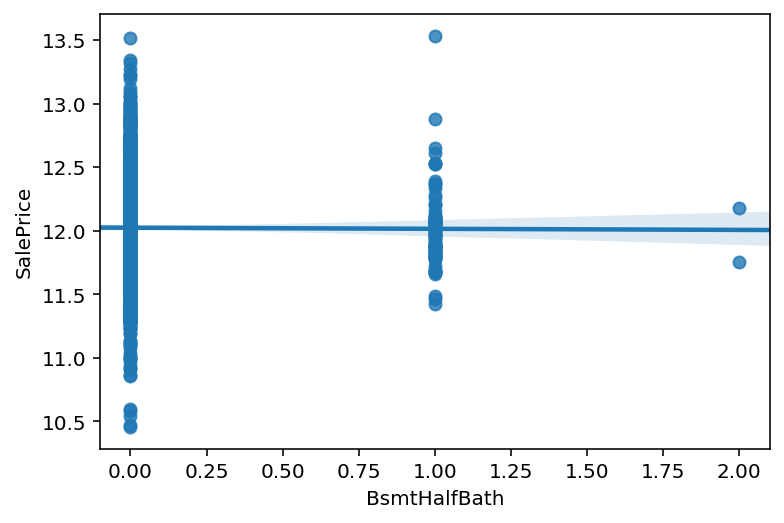

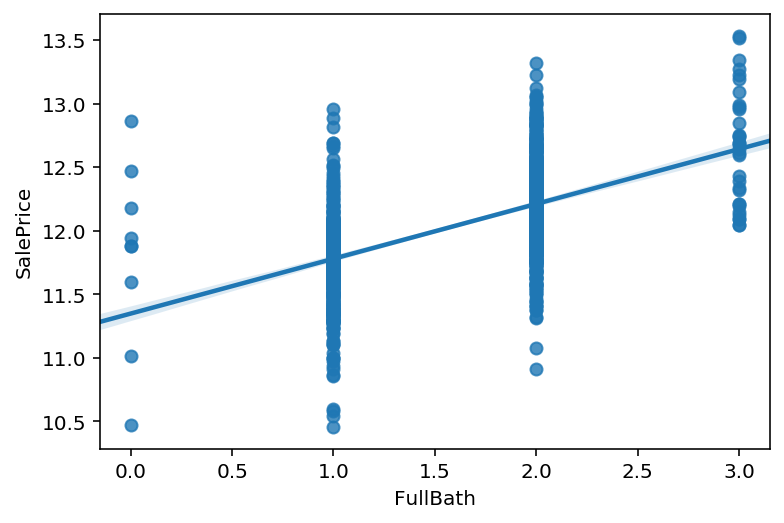

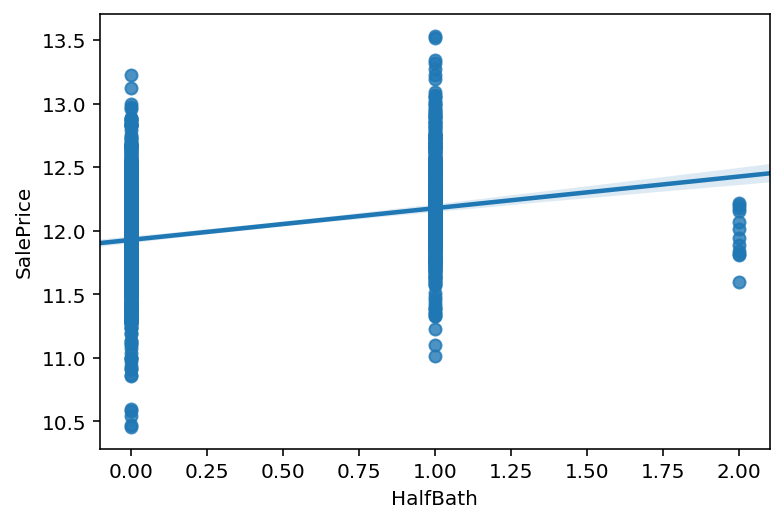

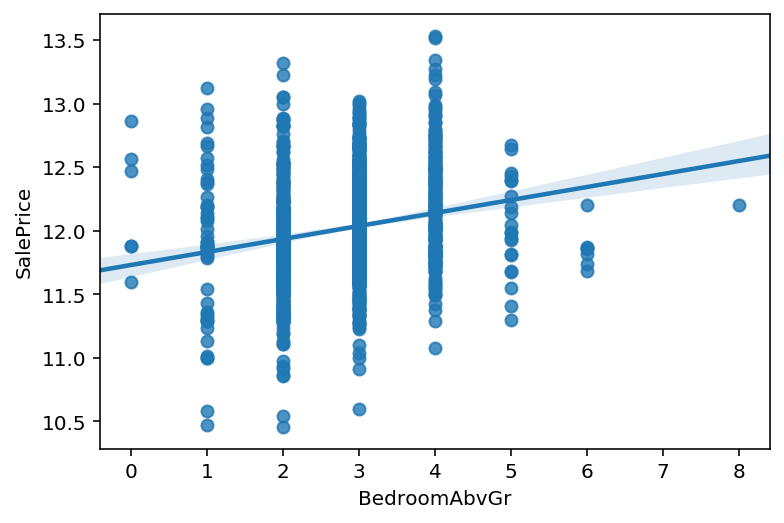

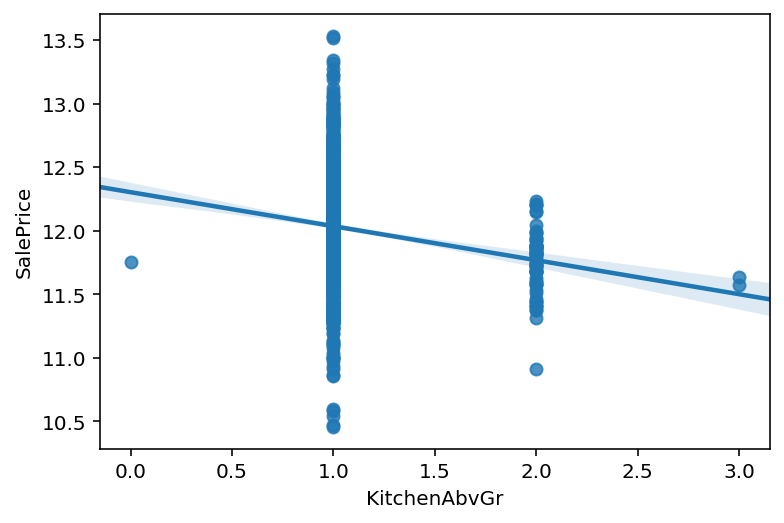

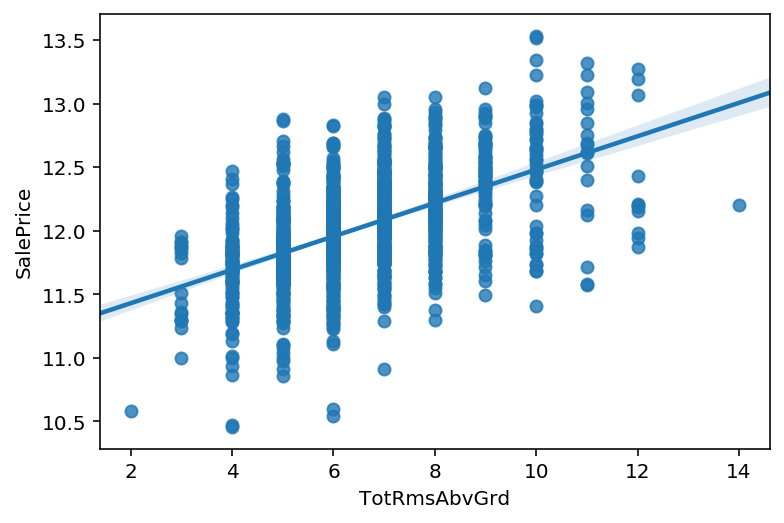

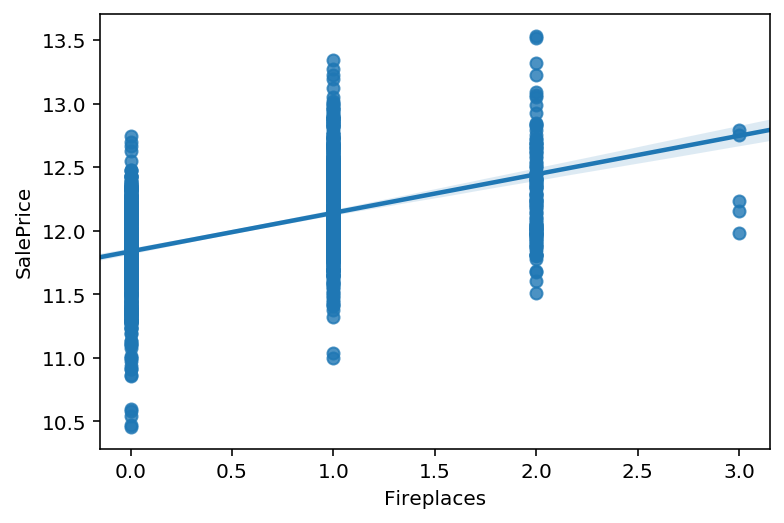

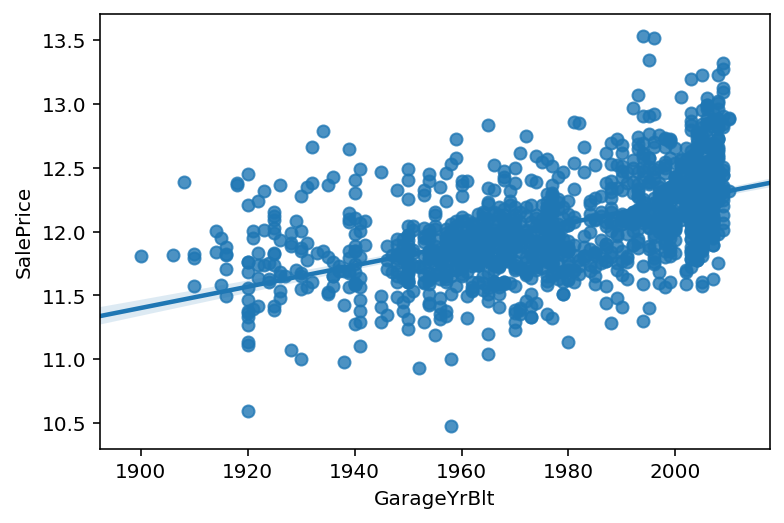

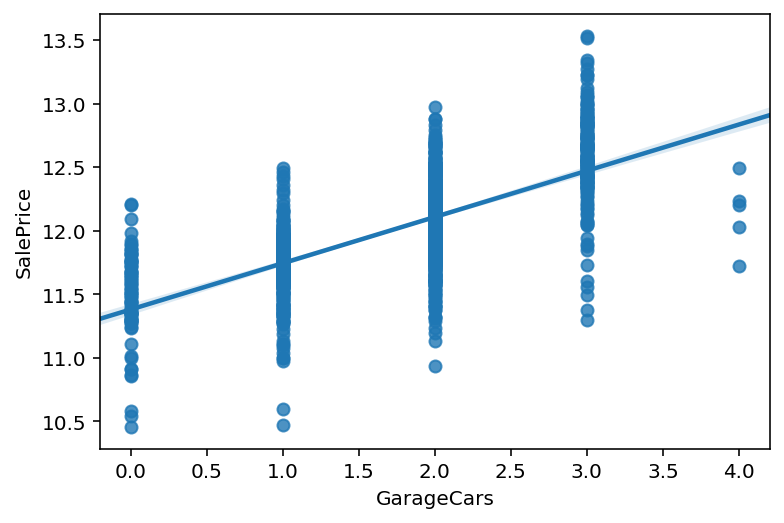

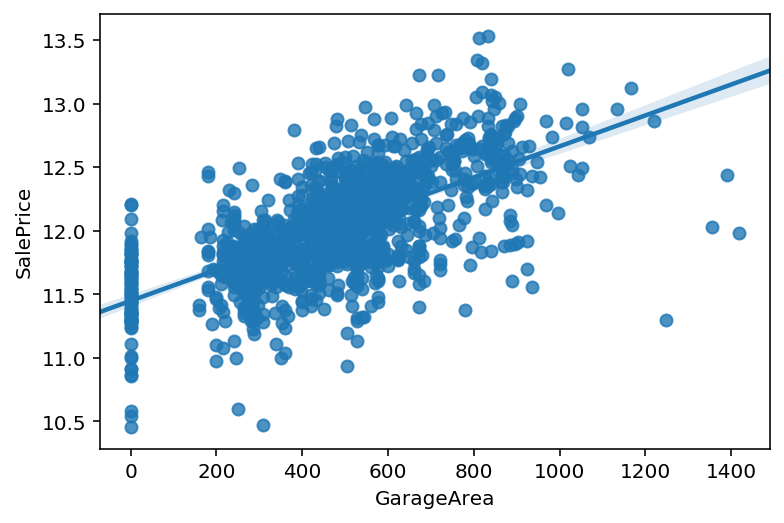

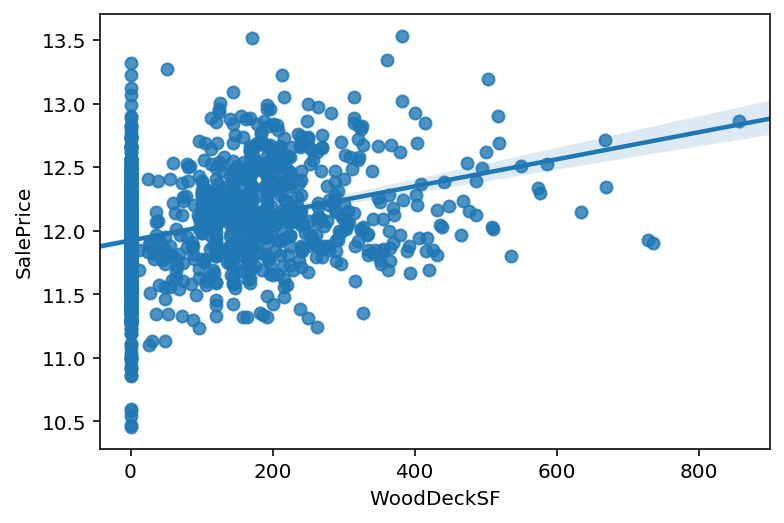

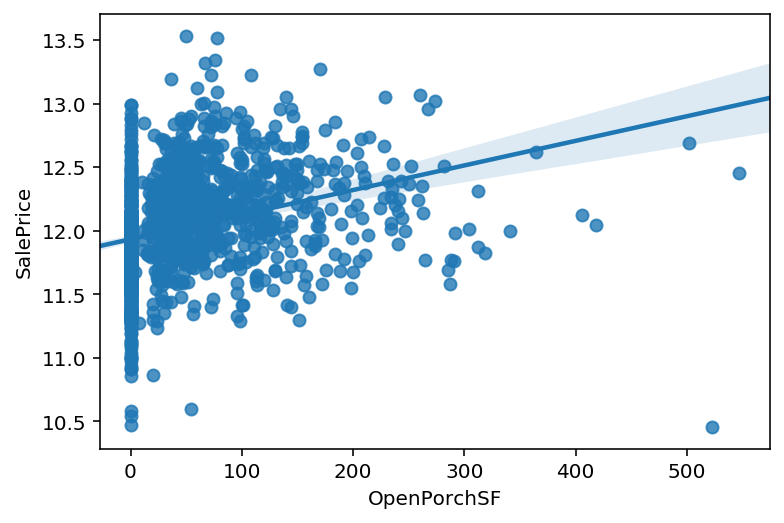

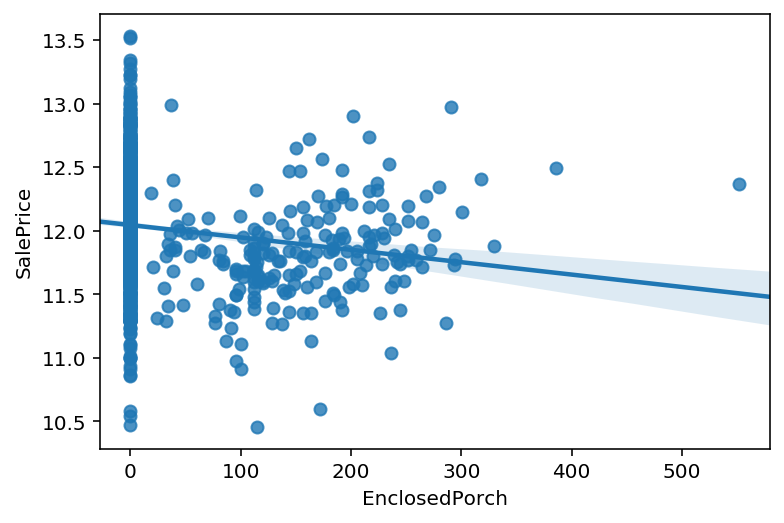

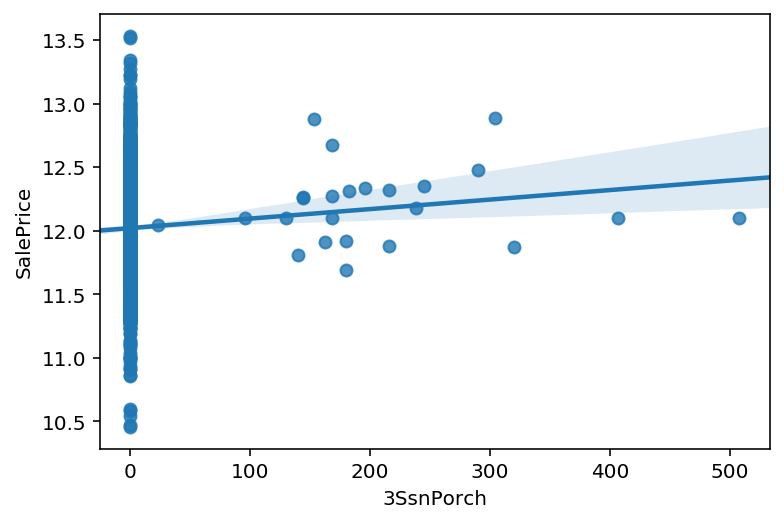

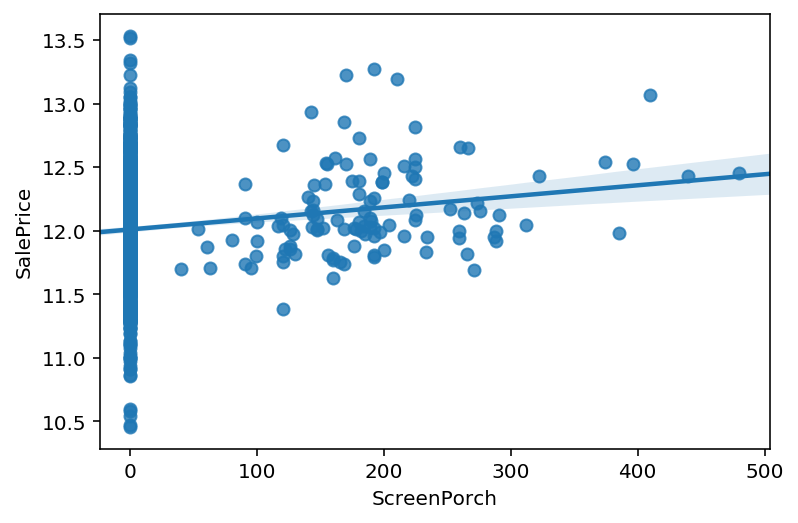

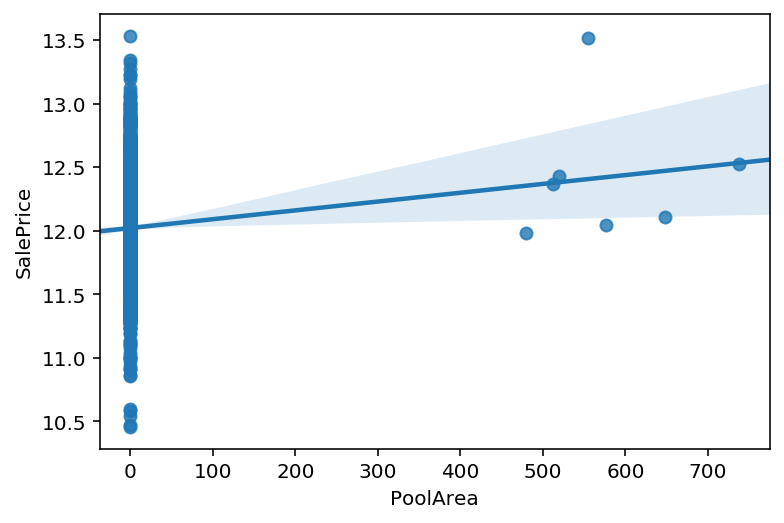

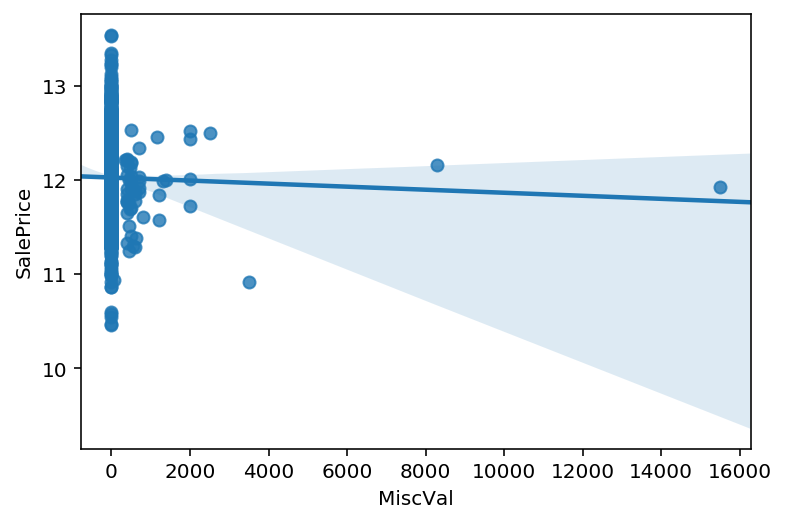

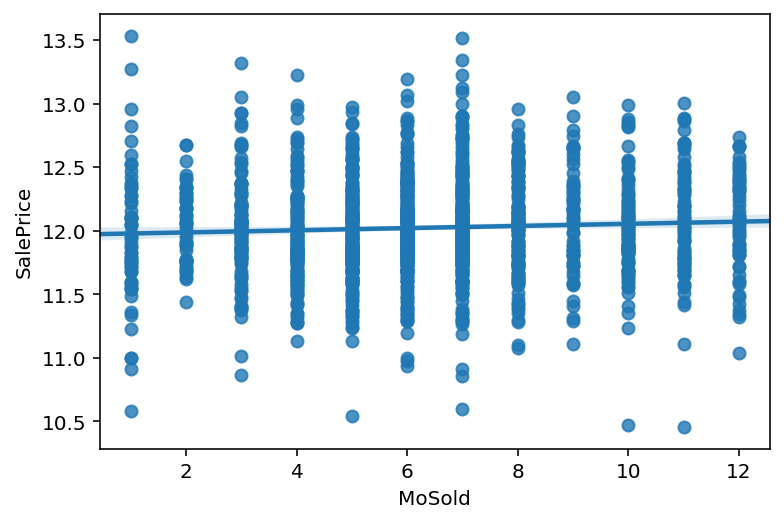

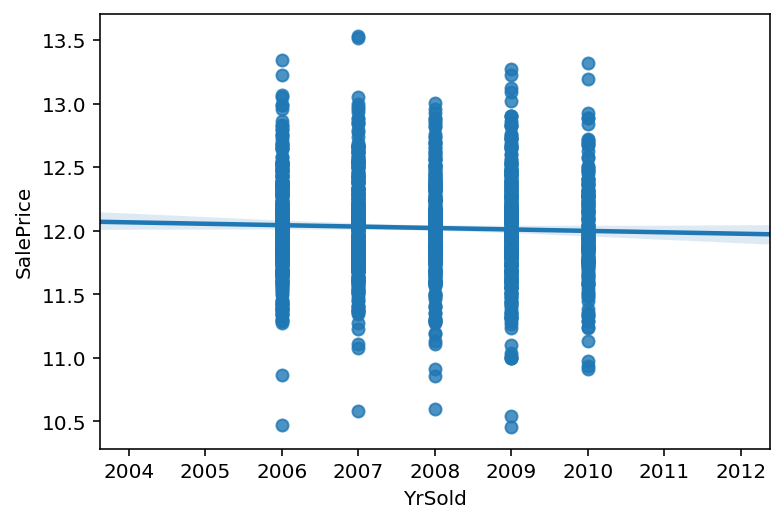

In [14]:
for feature in train[quan]:
    sns.regplot(x=feature,y='SalePrice', data=train)
    plt.show()

### Certaines features semblent avoir des outliers , Analyse une par une

* #### LotFrontage


corr : 0.36


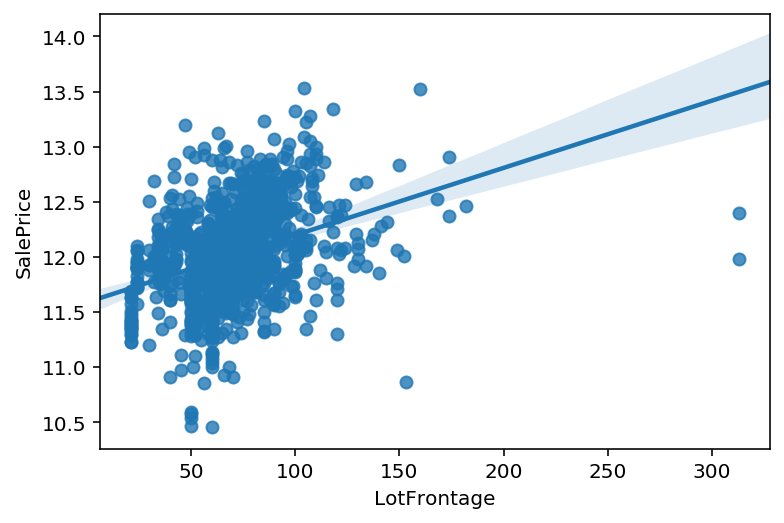

In [15]:
sns.regplot(x='LotFrontage',y='SalePrice', data=train)
print(f"corr : {round(train['LotFrontage'].corr(train['SalePrice']),2)}")

corr : 0.38


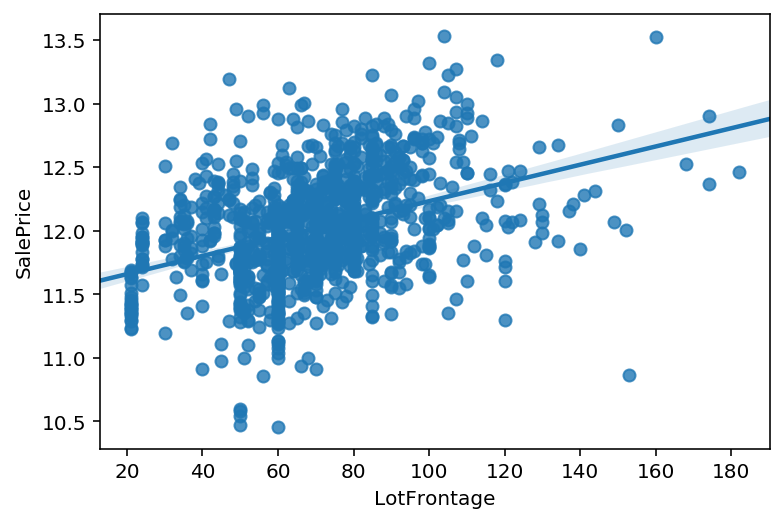

In [16]:
train = train.drop(train[(train['LotFrontage']>300)].index).reset_index(drop=True)
sns.regplot(x='LotFrontage',y='SalePrice', data=train)
print(f"corr : {round(train['LotFrontage'].corr(train['SalePrice']),2)}")

Suppression de deux outliers , augmentation de la corrélation

* #### LotArea

corr : 0.26


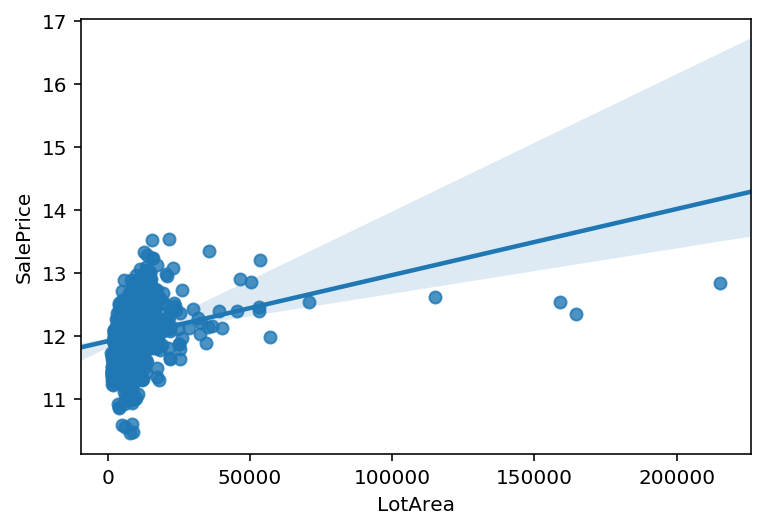

In [17]:
sns.regplot(x='LotArea',y='SalePrice', data=train)
print(f"corr : {round(train['LotArea'].corr(train['SalePrice']),2)}")

Outliers quand LotArea > 150k

corr : 0.34


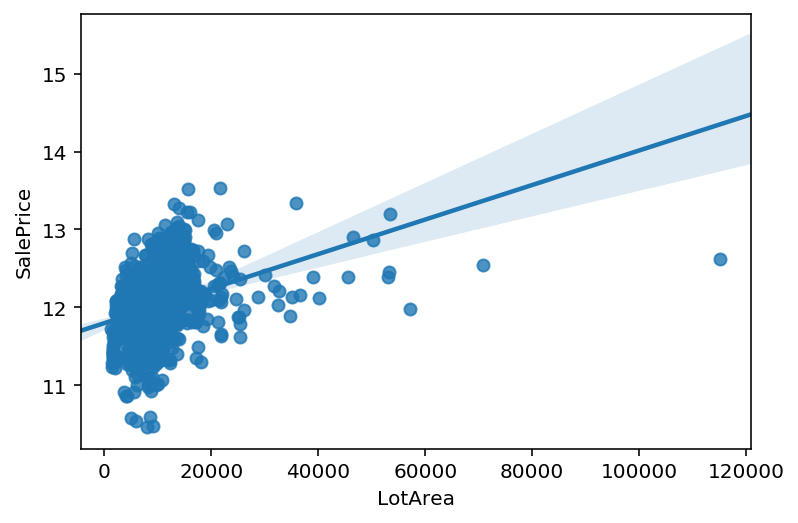

In [18]:
train = train.drop(train[(train['LotArea']>150000)].index).reset_index(drop=True)
sns.regplot(x='LotArea',y='SalePrice', data=train)
print(f"corr : {round(train['LotArea'].corr(train['SalePrice']),2)}")

* #### BsmtFinSF1

corr : 0.39


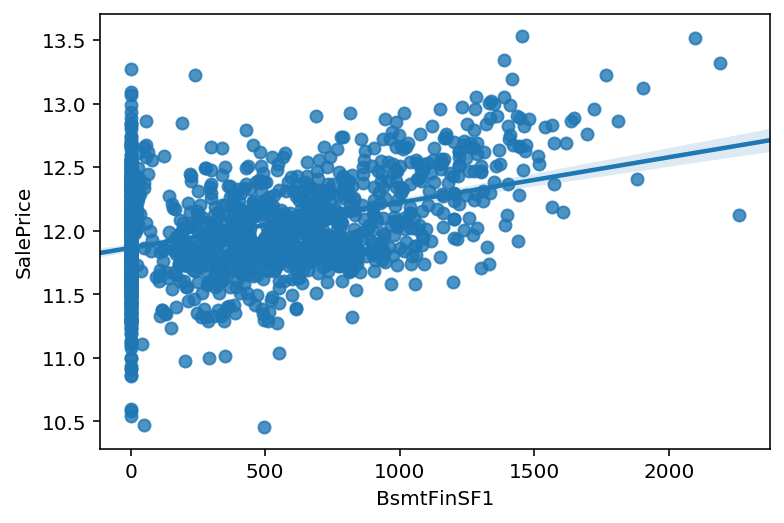

In [19]:
sns.regplot(x='BsmtFinSF1',y='SalePrice', data=train)
print(f"corr : {round(train['BsmtFinSF1'].corr(train['SalePrice']),2)}")

corr : 0.39


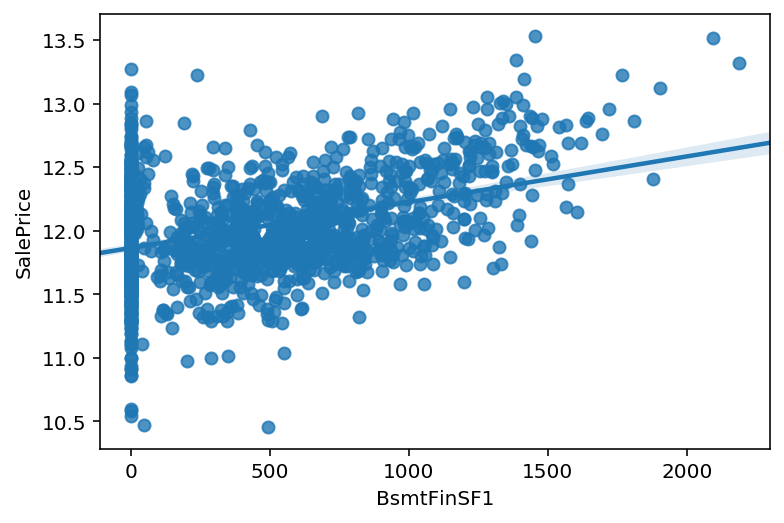

In [20]:
train = train.drop(train[(train['BsmtFinSF1']>2000) & (train['SalePrice']<12.5)].index).reset_index(drop=True)
sns.regplot(x='BsmtFinSF1',y='SalePrice', data=train)
print(f"corr : {round(train['BsmtFinSF1'].corr(train['SalePrice']),2)}")

Apparament pas trop d'impact

* #### GarageArea

corr : 0.66


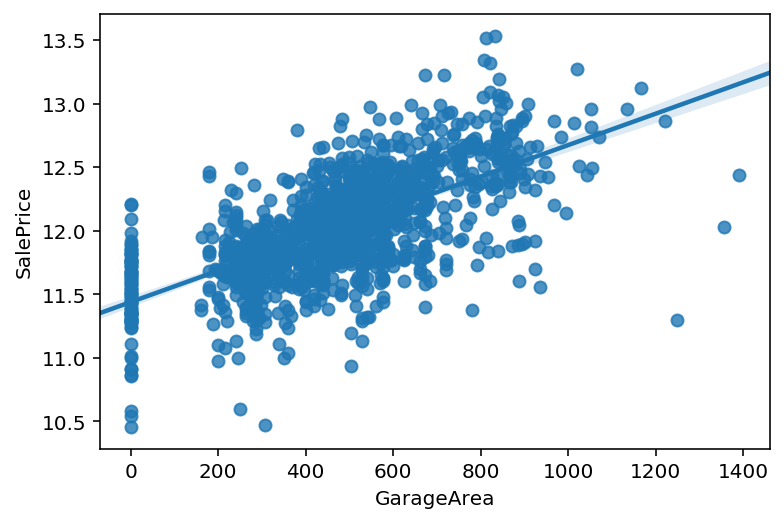

In [21]:
sns.regplot(x='GarageArea',y='SalePrice', data=train)
print(f"corr : {round(train['GarageArea'].corr(train['SalePrice']),2)}")

corr : 0.67


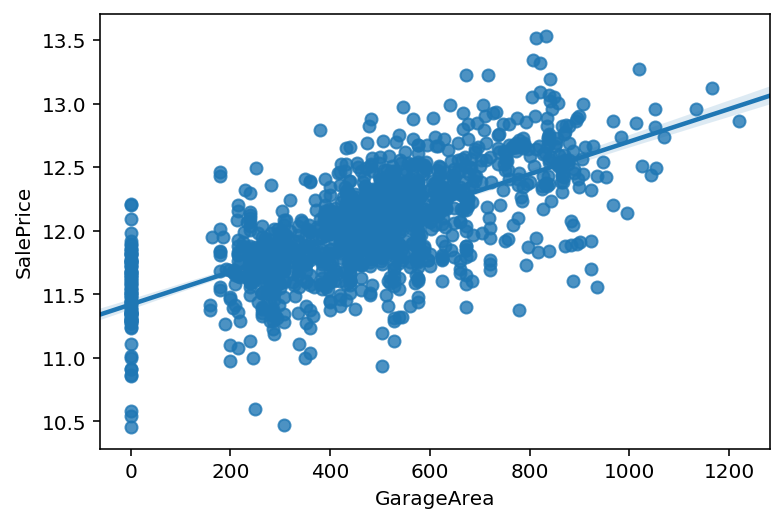

In [22]:
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<12.5)].index).reset_index(drop=True)
sns.regplot(x='GarageArea',y='SalePrice', data=train)
print(f"corr : {round(train['GarageArea'].corr(train['SalePrice']),2)}")

Amélioration de la corrélation

* #### GarageCars

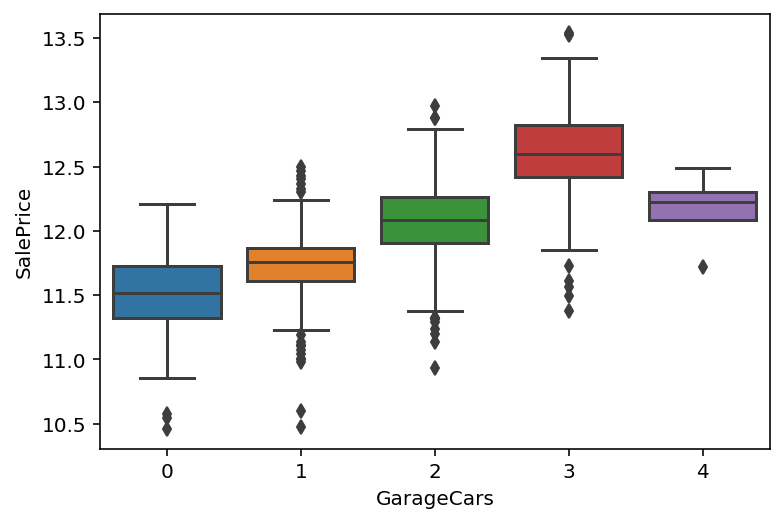

In [23]:
sns.boxplot(x=train['GarageCars'], y=train['SalePrice'])

In [24]:
train = train.drop(train[(train['GarageCars']>3) & (train['SalePrice']<12.5)].index).reset_index(drop=True)
print(f"corr : {round(train['GarageCars'].corr(train['SalePrice']),2)}")

corr : 0.69


* #### WoodDeckSF ( surface du plancher en bois ) 

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


corr : 0.34


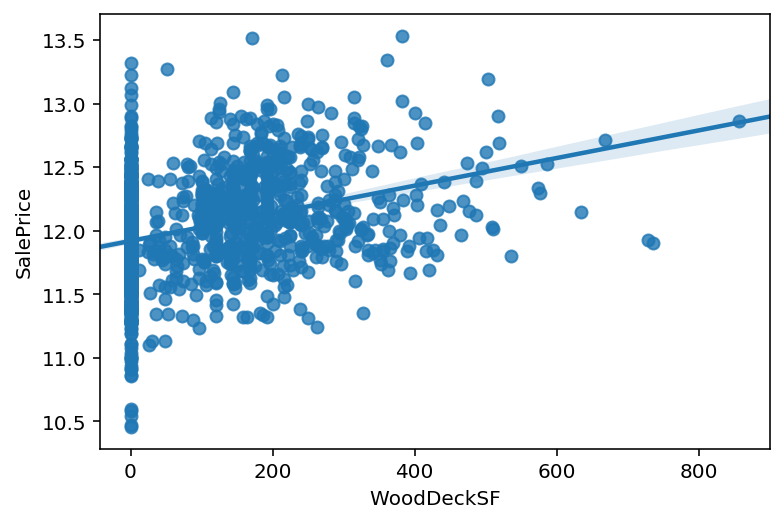

In [25]:
sns.regplot(x='WoodDeckSF',y='SalePrice', data=train)
print(f"corr : {round(train['WoodDeckSF'].corr(train['SalePrice']),2)}")
      

In [26]:
train = train.drop(train[(train['WoodDeckSF']>600) & (train['SalePrice']<12)].index).reset_index(drop=True)
print(f"corr : {round(train['WoodDeckSF'].corr(train['SalePrice']),2)}")

corr : 0.35


* #### OpenPorchSF

corr : 0.33


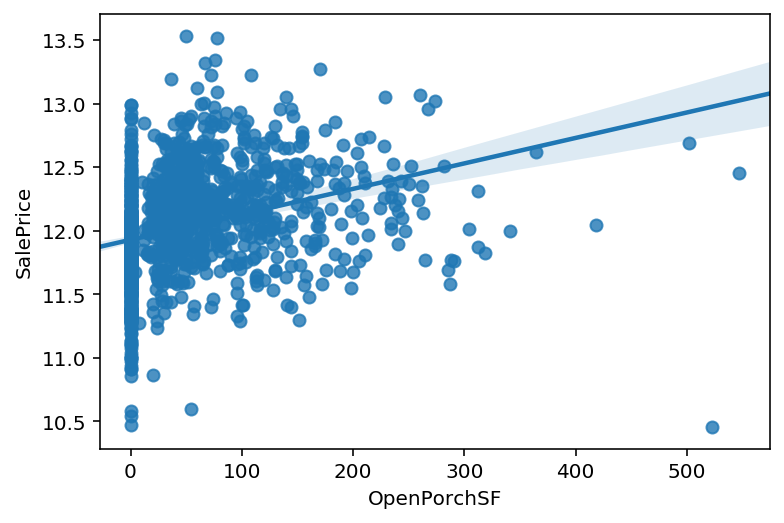

In [27]:
sns.regplot(x='OpenPorchSF',y='SalePrice', data=train)
print(f"corr : {round(train['OpenPorchSF'].corr(train['SalePrice']),2)}")

In [28]:
train = train.drop(train[(train['OpenPorchSF']>500) & (train['SalePrice']<11)].index).reset_index(drop=True)
print(f"corr : {round(train['OpenPorchSF'].corr(train['SalePrice']),2)}")

corr : 0.36


Globalement on amélioré les corrélations des features fortement corrélés avec le prix de vente en supprimant les outliers 


In [29]:
print(train.shape)
print(f"Supression de {1460-1444} outliers")

(1444, 80)
Supression de 16 outliers


## Traitement des valeurs manquantes dans le dataset

In [30]:
print(train.shape)
print(test.shape)

(1444, 80)
(1459, 79)


In [31]:
y_train = train.SalePrice.values
train.drop(['SalePrice'], axis=1, inplace=True)

### Valeurs manquantes dans le dataset

In [32]:
def hasnan(dataset):
    hasNAN = round((dataset.isnull().sum() / len(dataset)) * 100,2)  # toutes les features et leurs nombres de zéros ( % )
    hasNAN = hasNAN[hasNAN > 0] # On enleve celles qui n'ont pas de valeurs nulles 
    hasNAN = hasNAN.sort_values(ascending=False)
    missing_values = pd.DataFrame({'Missing Ratio': hasNAN})
    return missing_values

In [33]:
hasnan(train)

,Missing Ratio
PoolQC,99.58
MiscFeature,96.47
Alley,93.77
Fence,80.75
FireplaceQu,47.37
LotFrontage,17.73
GarageYrBlt,5.54
GarageType,5.54
GarageFinish,5.54
GarageQual,5.54


In [34]:
hasnan(test)

,Missing Ratio
PoolQC,99.79
MiscFeature,96.50
Alley,92.67
Fence,80.12
FireplaceQu,50.03
LotFrontage,15.56
GarageYrBlt,5.35
GarageCond,5.35
GarageQual,5.35
GarageFinish,5.35


In [35]:
def remplace_na(dataset):
    dataset["PoolQC"] = dataset["PoolQC"].fillna("None")
    dataset["MiscFeature"] = dataset["MiscFeature"].fillna("None")
    dataset["Alley"] = dataset["Alley"].fillna("None")
    dataset["Fence"] = dataset["Fence"].fillna("None")
    dataset["FireplaceQu"] = dataset["FireplaceQu"].fillna("None")
    dataset["LotFrontage"] = dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        dataset[col] = dataset[col].fillna('None')
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        dataset[col] = dataset[col].fillna(0)
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        dataset[col] = dataset[col].fillna(0)
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        dataset[col] = dataset[col].fillna('None')
    dataset["MasVnrType"] = dataset["MasVnrType"].fillna("None")
    dataset["MasVnrArea"] = dataset["MasVnrArea"].fillna(0)
    dataset['MSZoning'] = dataset.groupby("Neighborhood")['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    dataset = dataset.drop(['Utilities'], axis=1)
    dataset["Functional"] = dataset["Functional"].fillna("Typ")
    dataset['Electrical'] = dataset['Electrical'].fillna(dataset['Electrical'].mode()[0])
    dataset['KitchenQual'] = dataset['KitchenQual'].fillna(dataset['KitchenQual'].mode()[0])
    dataset['Exterior1st'] = dataset['Exterior1st'].fillna(dataset['Exterior1st'].mode()[0])
    dataset['Exterior2nd'] = dataset['Exterior2nd'].fillna(dataset['Exterior2nd'].mode()[0])
    dataset['SaleType'] = dataset['SaleType'].fillna(dataset['SaleType'].mode()[0])
    dataset['MSSubClass'] = dataset['MSSubClass'].fillna("None")
    return dataset

In [36]:
train = remplace_na(train)
test = remplace_na(test)

In [37]:
hasnan(train)

,Missing Ratio


In [38]:
hasnan(test)

,Missing Ratio


Il n'y a plus de valeurs manquantes 

## Modifications de features

In [39]:
def my_encoder(dataset):
    dataset.Alley = dataset.Alley.map({'None':0, 'Grvl':1, 'Pave':1})
    dataset.BsmtCond =  dataset.BsmtCond.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.BsmtExposure = dataset.BsmtExposure.map({'None':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
    dataset['BsmtFinType1'] = dataset['BsmtFinType1'].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    dataset['BsmtFinType2'] = dataset['BsmtFinType2'].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
    dataset.BsmtQual = dataset.BsmtQual.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.ExterCond = dataset.ExterCond.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.ExterQual = dataset.ExterQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.FireplaceQu = dataset.FireplaceQu.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.Functional = dataset.Functional.map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8})
    dataset.GarageCond = dataset.GarageCond.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.GarageQual = dataset.GarageQual.map({'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.HeatingQC = dataset.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.KitchenQual = dataset.KitchenQual.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    dataset.LandSlope = dataset.LandSlope.map({'Sev':1, 'Mod':2, 'Gtl':3}) 
    dataset.PavedDrive = dataset.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    dataset.PoolQC = dataset.PoolQC.map({'None':0, 'Fa':1, 'TA':1, 'Gd':1, 'Ex':1})
    dataset.Street = dataset.Street.map({'Grvl':1, 'Pave':2})
    dataset.GarageFinish = dataset.GarageFinish.map(({'None':0 ,'Unf':1 ,'RFn':2, 'Fin':3}))
    dataset.CentralAir = dataset.CentralAir.map(({'N':0 ,'Y':1}))

    # quanti => quali
    dataset.MSSubClass = dataset.MSSubClass.map({20:'class1', 30:'class2', 40:'class3', 45:'class4',
                                       50:'class5', 60:'class6', 70:'class7', 75:'class8',
                                       80:'class9', 85:'class10', 90:'class11', 120:'class12',
                                       150:'class13', 160:'class14', 180:'class15', 190:'class16'})
    return dataset

In [40]:
my_encoder(train)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,class6,RL,65.0,8450,2,0,Reg,Lvl,Inside,3,...,0,0,0,None,None,0,2,2008,WD,Normal
1,class1,RL,80.0,9600,2,0,Reg,Lvl,FR2,3,...,0,0,0,None,None,0,5,2007,WD,Normal
2,class6,RL,68.0,11250,2,0,IR1,Lvl,Inside,3,...,0,0,0,None,None,0,9,2008,WD,Normal
3,class7,RL,60.0,9550,2,0,IR1,Lvl,Corner,3,...,0,0,0,None,None,0,2,2006,WD,Abnorml
4,class6,RL,84.0,14260,2,0,IR1,Lvl,FR2,3,...,0,0,0,None,None,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,class1,FV,62.0,7500,2,1,Reg,Lvl,Inside,3,...,0,0,0,None,None,0,10,2009,WD,Normal
1440,class6,RL,62.0,7917,2,0,Reg,Lvl,Inside,3,...,0,0,0,None,None,0,8,2007,WD,Normal
1441,class1,RL,85.0,13175,2,0,Reg,Lvl,Inside,3,...,0,0,0,MnPrv,None,0,2,2010,WD,Normal
1442,class7,RL,66.0,9042,2,0,Reg,Lvl,Inside,3,...,0,0,0,GdPrv,Shed,2500,5,2010,WD,Normal


In [41]:
my_encoder(test)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,class1,RH,80.0,11622,2,0,Reg,Lvl,Inside,3,...,120,0,0,MnPrv,None,0,6,2010,WD,Normal
1,class1,RL,81.0,14267,2,0,IR1,Lvl,Corner,3,...,0,0,0,None,Gar2,12500,6,2010,WD,Normal
2,class6,RL,74.0,13830,2,0,IR1,Lvl,Inside,3,...,0,0,0,MnPrv,None,0,3,2010,WD,Normal
3,class6,RL,78.0,9978,2,0,IR1,Lvl,Inside,3,...,0,0,0,None,None,0,6,2010,WD,Normal
4,class12,RL,43.0,5005,2,0,IR1,HLS,Inside,3,...,144,0,0,None,None,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,class14,RM,21.0,1936,2,0,Reg,Lvl,Inside,3,...,0,0,0,None,None,0,6,2006,WD,Normal
1455,class14,RM,21.0,1894,2,0,Reg,Lvl,Inside,3,...,0,0,0,None,None,0,4,2006,WD,Abnorml
1456,class1,RL,160.0,20000,2,0,Reg,Lvl,Inside,3,...,0,0,0,None,None,0,9,2006,WD,Abnorml
1457,class10,RL,62.0,10441,2,0,Reg,Lvl,Inside,3,...,0,0,0,MnPrv,Shed,700,7,2006,WD,Normal


Features sur le Garage, sur les Exterieurs et sur les Bsmt

In [42]:
def sum_columns(dataset):
    dataset['GarageQual']=dataset['GarageQual']+dataset['GarageCond']
    dataset['ExterQual']=dataset['ExterQual']+dataset['ExterCond']
    dataset['BsmtFinType']= (dataset['BsmtFinType1']+dataset['BsmtFinType2'])*(5/3)  #pour faire une note sur 20
    dataset['BsmtQual']= (dataset['BsmtQual']+dataset['BsmtCond']+dataset['BsmtExposure'])*(4/3)  #pour faire une note sur 20
    return dataset

In [43]:
sum_columns(train)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BsmtFinType
0,class6,RL,65.0,8450,2,0,Reg,Lvl,Inside,3,...,0,0,None,None,0,2,2008,WD,Normal,11.666667
1,class1,RL,80.0,9600,2,0,Reg,Lvl,FR2,3,...,0,0,None,None,0,5,2007,WD,Normal,10.000000
2,class6,RL,68.0,11250,2,0,IR1,Lvl,Inside,3,...,0,0,None,None,0,9,2008,WD,Normal,11.666667
3,class7,RL,60.0,9550,2,0,IR1,Lvl,Corner,3,...,0,0,None,None,0,2,2006,WD,Abnorml,10.000000
4,class6,RL,84.0,14260,2,0,IR1,Lvl,FR2,3,...,0,0,None,None,0,12,2008,WD,Normal,11.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,class1,FV,62.0,7500,2,1,Reg,Lvl,Inside,3,...,0,0,None,None,0,10,2009,WD,Normal,11.666667
1440,class6,RL,62.0,7917,2,0,Reg,Lvl,Inside,3,...,0,0,None,None,0,8,2007,WD,Normal,3.333333
1441,class1,RL,85.0,13175,2,0,Reg,Lvl,Inside,3,...,0,0,MnPrv,None,0,2,2010,WD,Normal,13.333333
1442,class7,RL,66.0,9042,2,0,Reg,Lvl,Inside,3,...,0,0,GdPrv,Shed,2500,5,2010,WD,Normal,11.666667


In [44]:
sum_columns(test)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,BsmtFinType
0,class1,RH,80.0,11622,2,0,Reg,Lvl,Inside,3,...,0,0,MnPrv,None,0,6,2010,WD,Normal,8.333333
1,class1,RL,81.0,14267,2,0,IR1,Lvl,Corner,3,...,0,0,None,Gar2,12500,6,2010,WD,Normal,10.000000
2,class6,RL,74.0,13830,2,0,IR1,Lvl,Inside,3,...,0,0,MnPrv,None,0,3,2010,WD,Normal,11.666667
3,class6,RL,78.0,9978,2,0,IR1,Lvl,Inside,3,...,0,0,None,None,0,6,2010,WD,Normal,11.666667
4,class12,RL,43.0,5005,2,0,IR1,HLS,Inside,3,...,0,0,None,None,0,1,2010,WD,Normal,10.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,class14,RM,21.0,1936,2,0,Reg,Lvl,Inside,3,...,0,0,None,None,0,6,2006,WD,Normal,3.333333
1455,class14,RM,21.0,1894,2,0,Reg,Lvl,Inside,3,...,0,0,None,None,0,4,2006,WD,Abnorml,6.666667
1456,class1,RL,160.0,20000,2,0,Reg,Lvl,Inside,3,...,0,0,None,None,0,9,2006,WD,Abnorml,10.000000
1457,class10,RL,62.0,10441,2,0,Reg,Lvl,Inside,3,...,0,0,MnPrv,Shed,700,7,2006,WD,Normal,11.666667


In [45]:
# drop columns
def drop_columns(dataset, liste):
    dataset = dataset.drop(columns=liste)
    return dataset

list_columns =['Condition2', 'Exterior2nd', 'PoolArea', 
               'GarageCond', 'ExterCond', 'BsmtFinType1', 
               'BsmtFinType2', 'BsmtCond', 'BsmtExposure',
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF']

In [46]:
train_dropped = drop_columns(train, list_columns)
print(train.shape)
print(train_dropped.shape)

(1444, 79)
(1444, 67)


In [47]:
test_dropped = drop_columns(test, list_columns)
print(test.shape)
print(test_dropped.shape)

(1459, 79)
(1459, 67)


In [48]:
test = test_dropped
train = train_dropped

#### Mise à jour features quali/quanti

In [49]:
#quanti
quan = train.select_dtypes(include=['int64','float64']).columns

In [50]:
# quali
qual = train.select_dtypes(include=['object']).columns

In [51]:
print(f"{len(quan)} features quantitatives")

46 features quantitatives


In [52]:
print(f"{len(qual)} features qualitatives")

21 features qualitatives


In [53]:
quan

Index(['LotFrontage', 'LotArea', 'Street', 'Alley', 'LandSlope', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual',
       'BsmtQual', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolQC', 'MiscVal', 'MoSold', 'YrSold', 'BsmtFinType'],
      dtype='object')

In [54]:
%store quan

Stored 'quan' (Index)


In [55]:
qual

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig',
       'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'MasVnrType', 'Foundation', 'Heating',
       'Electrical', 'GarageType', 'Fence', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

### Dummies variables

In [56]:
train = pd.get_dummies(train, columns=qual, drop_first=True)

In [57]:
test = pd.get_dummies(test, columns=qual, drop_first=True)

In [58]:
train.shape

(1444, 186)

In [59]:
test.shape

(1459, 177)

#### On cherche les colonnes qui sont dans le test mais pas dans le train

In [60]:
missing_train_cols = pd.DataFrame(columns = [feature for feature in test.columns.values if feature not in train.columns.values])

In [61]:
missing_train_cols

,MSSubClass_class13


#### On cherche les colonnes qui sont dans le train mais pas dans le test

In [62]:
missing_test_cols = pd.DataFrame(columns = [feature for feature in train.columns.values if feature not in test.columns.values])

In [63]:
missing_test_cols

,HouseStyle_2.5Fin,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,Exterior1st_ImStucc,Exterior1st_Stone,Heating_GasA,Heating_OthW,Electrical_Mix,MiscFeature_TenC


In [64]:
train = pd.concat([train,missing_train_cols], axis=1, verify_integrity = True)

In [65]:
test = pd.concat([test,missing_test_cols,], axis=1, verify_integrity = True )

#### On met les deux dataset dans le meme ordre 

In [66]:
test = test[train.columns.values]

In [67]:
train.head()

,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_class13
0,65.0,8450,2,0,3,7,5,2003,2003,196.0,...,0,0,0,1,0,0,0,1,0,NaN
1,80.0,9600,2,0,3,6,8,1976,1976,0.0,...,0,0,0,1,0,0,0,1,0,NaN
2,68.0,11250,2,0,3,7,5,2001,2002,162.0,...,0,0,0,1,0,0,0,1,0,NaN
3,60.0,9550,2,0,3,7,5,1915,1970,0.0,...,0,0,0,1,0,0,0,0,0,NaN
4,84.0,14260,2,0,3,8,5,2000,2000,350.0,...,0,0,0,1,0,0,0,1,0,NaN


In [68]:
test.head()

,LotFrontage,LotArea,Street,Alley,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_class13
0,80.0,11622,2,0,3,5,6,1961,1961,0.0,...,0,0,0,1,0,0,0,1,0,0
1,81.0,14267,2,0,3,6,6,1958,1958,108.0,...,0,0,0,1,0,0,0,1,0,0
2,74.0,13830,2,0,3,5,5,1997,1998,0.0,...,0,0,0,1,0,0,0,1,0,0
3,78.0,9978,2,0,3,6,6,1998,1998,20.0,...,0,0,0,1,0,0,0,1,0,0
4,43.0,5005,2,0,3,8,5,1992,1992,0.0,...,0,0,0,1,0,0,0,1,0,0


#### On remplit les nouvelles colonnes par des zéros

In [69]:
test = test.fillna(0)

In [70]:
train = train.fillna(0)

In [71]:
print(train.shape)
print(test.shape)

(1444, 187)
(1459, 187)


In [72]:
X_train = train
X_test = test

### Scaler

In [73]:
y_train

array([12.24769912, 12.10901644, 12.31717117, ..., 12.25486757,
       12.49313327, 11.86446927])

In [74]:
scaler_X = RobustScaler()
X_train[quan] = scaler_X.fit_transform(X_train[quan])
X_test[quan] = scaler_X.transform(X_test[quan])